In [1]:
import sys, os
import numpy as np
# import h5py

from pygama.dsp.ProcessingChain import ProcessingChain
from pygama.dsp.processors import *
from pygama.dsp.units import *

from pygama.io import io_base as io

# CONSTANT VARIABLES TO SET UP CONFIG
# with h5py.File("/Volumes/LaCie/Data/CAGE/pygama_raw/raw_run11.lh5", 'r') as f:
#     print(f.keys())
filename = os.path.expandvars("/Volumes/LaCie/Data/CAGE/pygama_raw/raw_run11.lh5")
groupname = "/ORSIS3302DecoderForEnergy"
nentries = 1000 # Number of entries in the file to process
start_entry = 0 # First entry to process
verbosity = 2
wfblock = 8

In [2]:
# Set up file I/O
lh5 = io.LH5Store()
data = lh5.read_object(groupname, filename, n_rows=nentries, start_row=start_entry)

wf_in = data['waveform']['values'].nda
dt = data['waveform']['dt'].nda[0] * unit_parser.parse_unit(data['waveform']['dt'].attrs['units'])

# Set up processing chain
proc = ProcessingChain(block_width=wfblock, clock_unit=dt, verbosity=verbosity)
proc.add_input_buffer("wf", wf_in, dtype='float32')

# Basic Filters
proc.add_processor(mean_stdev, "wf[0:1000]", "bl", "bl_sig")
proc.add_processor(np.subtract, "wf", "bl", "wf_blsub")
proc.add_processor(pole_zero, "wf_blsub", 70*us, "wf_pz")
proc.add_processor(trap_filter, "wf_pz", 10*us, 5*us, "wf_trap")
proc.add_processor(asymTrapFilter, "wf_pz", 10*us, 5*us, 10*us, "wf_atrap")

# Energy calculation
proc.add_processor(np.divide, "wf_trap", 10*us, "trap_norm")
# proc.add_processor(np.divide, "wf_atrap", 10*us, "atrap_norm")
proc.add_processor(np.amax, "wf_atrap", 1, "atrapE", signature='(n),()->()', types=['fi->f'])
# proc.add_processor(np.amax, "trap_norm", 1, "trapE", signature='(n),()->()', types=['fi->f'])

# Current calculation
proc.add_processor(avg_current, "wf_pz", 10, "curr")
proc.add_processor(np.amax, "curr", 1, "curr_amp", signature='(n),()->()', types=['fi->f'])


Setting i/o buffer length to 1000
Added variable wf with shape (8, 3000) and type float32
Binding input buffer of shape (1000, 3000) and type uint16 to variable wf with shape (8, 3000) and type float32
Added variable bl with shape (8,) and type float32
Added variable bl_sig with shape (8,) and type float32
Added processor: mean_stdev(wf, bl, bl_sig)
Added variable wf_blsub with shape (8, 3000) and type float32
Added processor: subtract(wf, bl, wf_blsub)
Added variable wf_pz with shape (8, 3000) and type float32
Added processor: pole_zero(wf_blsub, 7000.0, wf_pz)
Added variable wf_trap with shape (8, 3000) and type float32
Added processor: trap_filter(wf_pz, 1000, 500, wf_trap)
Added variable wf_atrap with shape (8, 3000) and type float32
Added processor: asymTrapFilter(wf_pz, 1000, 500, 1000, wf_atrap)
Added variable trap_norm with shape (8, 3000) and type float32
Added processor: true_divide(wf_trap, 1000.0, trap_norm)
Added variable atrapE with shape (8,) and type float32
Added proce

In [3]:
# Get the outputs of interest
wf = proc.get_output_buffer("wf_blsub")
trap = proc.get_output_buffer("trap_norm")
atrap = proc.get_output_buffer("wf_atrap")
trapE = proc.get_output_buffer("atrapE")
curr = proc.get_output_buffer("curr")
curr_amp = proc.get_output_buffer("curr_amp")

wfindex = np.arange(trap.shape[-1])

# Execute analysis
proc.execute()


Binding output buffer of shape (1000, 3000) and type float32 to variable wf_blsub with shape (8, 3000) and type float32
Binding output buffer of shape (1000, 3000) and type float32 to variable trap_norm with shape (8, 3000) and type float32
Binding output buffer of shape (1000, 3000) and type float32 to variable wf_atrap with shape (8, 3000) and type float32
Binding output buffer of shape (1000,) and type float32 to variable atrapE with shape (8,) and type float32
Binding output buffer of shape (1000, 3000) and type float32 to variable curr with shape (8, 3000) and type float32
Binding output buffer of shape (1000,) and type float32 to variable curr_amp with shape (8,) and type float32


In [4]:
# Set index counter. Rerun this box to start over the file...
wfnum = 0

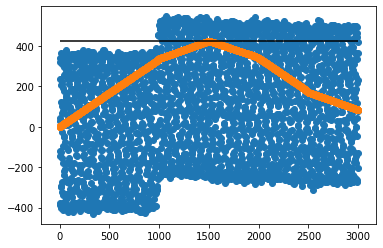

In [19]:
import matplotlib.pyplot as plt

# Draw things!
plt.scatter(wfindex, wf[wfnum])
# plt.scatter(wfindex, trap[wfnum])
plt.scatter(wfindex, atrap[wfnum])
# plt.scatter(wfindex, curr[wfnum])
plt.hlines(trapE[wfnum], wfindex[0], wfindex[-1])
# plt.hlines(curr_amp[wfnum], wfindex[0], wfindex[-1])

wfnum+=1